In [1]:
# Importing libraries
from data_driven.modeling.scripts.tuning import rfc_parameter_tuning
from data_driven.modeling.scripts.ancillary import (drive_authentication, npz_files, open_dataset,
                                                    cv_and_y_random, save_best_params,
                                                   rfc_draw_convergence)
from data_driven.modeling.scripts.evaluation import performing_cross_validation, data_driven_models_ranking
from data_driven.modeling.scripts.metrics import prediction_evaluation

%matplotlib inline
from skopt.space import Integer, Categorical
import pandas as pd
import time
from sklearn.metrics import plot_confusion_matrix
import pickle
import os
import matplotlib.pyplot as plt
import time

2022-02-25 12:54:36.394607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 12:54:36.394633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Accessing the data 

If you will use Google Drive, you have to enable Google Drive and obtain the client secrets file client_secrets.json (see the following [link](https://developers.google.com/drive/api/v3/enable-drive-api) or [this other](https://www.geeksforgeeks.org/get-list-of-files-and-folders-in-google-drive-storage-using-python/))

In [2]:
# Connecting to Google Drive
# client_secrets.json need to be in the same directory as the script

drive = drive_authentication()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=128273080156-gak8id4v61mj7jjdqqucv74kc5volhj0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


If you need to check the folder on where you have stored the data for running the multi-class classification algorithm, use the folder ID and the function just below

In [3]:
# When you share a folder/file from Google Drive by using its shareable link you will see tomething like 
# https://drive.google.com/drive/folders/{ID_element}?usp=sharing. You can take the ID_element

multi_model_data_folder_id = '1fuRH83b2-hoJj4BtZNZL2uNlalqREHaN'
ids = npz_files(multi_model_data_folder_id, drive)
ids

{'36': '1VjS-d3t_1_pLRb0DeCvzwFkYY4g7TR39',
 '35': '1IpFA1n4HyNRnbqD7BQrUovv3uOmUjUM7',
 '34': '1uoNoepe14Ai_7iynUXpiv8KnNua4vG-7',
 '33': '1sguHXi88heZdQN1IoDJaAm6Z0V3tG7Sz',
 '32': '1LjiuqnS6p7zKABsTQVspdk5fzN2Yjrp2',
 '31': '1GZSRYAcl9lBq-afM-aAkxF2UlZpN-cxx',
 '30': '1Q1GcB1sAk7SyARftWwRAgWseuqt2osWb',
 '29': '1yWkA8lltolU7WBDIxwZO2AXtNwameffY',
 '28': '1l8c1STS9B17lIfKZRGubjLyEHadOz_It',
 '27': '1w7W01iQ1wbZwhCVc6lE5lmKACtNMK1wc',
 '26': '1_IQKPnksZnfNYUZpXR7fA1sEIo5ffU-0',
 '25': '142bWAFtxtj_DL8pI7LWkrTnnSF1VaQSc',
 '24': '1m8o2C8KJCQQ6-y094c8JNZgzpMJejO_1',
 '23': '1Chik48HNN_i5AklEGTiay0quTto0UrA-',
 '22': '1xHg-sXahTICHd6UYN3X-V2xf0gtD5t4c',
 '21': '1iP7eDEIH2jOQrLcphxRbTSRk2sK3ghaA',
 '20': '1i4F6Vj2uhQuLP0WzNcTXiaK18F-9pIo8',
 '19': '1l48yak-8uY5sgeVEF52jLhZrm5fhZ5D2',
 '18': '1s7h1K6yOgT-17TbgouqHec0mwfeKFUJV',
 '17': '1eJHw4TT_vs6JINmGAWekKav8cMVzcaen',
 '16': '1xxdhmGiPUtf8tOZxYRCuZmsDTHxIibyr',
 '15': '1qOuarPq381X2alUPdjDKihWDNQdTlruB',
 '14': '1fb8w02hcNkqAKUyDu1ySSBI

# 2. Building RFC with default parameters

In [4]:
# Default parameters
model_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 200,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [5]:
df_results = pd.DataFrame()

for id, key in ids.items():
    
    print(f'Evaluating base model for data preparation id {id}\n')
    
    # Opening the dataset
    X_train, Y_train = open_dataset(id, key, drive, test=False)
    
    # Y-randomization and cross-validation
    start = time.time()
    df_temporary = cv_and_y_random(id, X_train, Y_train.reshape(Y_train.shape[0],),
                                            model_params, 'RFC', 'multi-model binary classification',
                                            threshold=0.75
                                            )
    end = time.time()
    df_temporary['time_sec'] = end - start
    df_temporary['n_samples'] = X_train.shape[0]
    df_temporary['n_bytes'] = X_train.nbytes
    df_results = pd.concat([df_results,
                            df_temporary
                           ],
                          axis=0,
                          ignore_index=True)

Evaluating base model for data preparation id 36

X train has the following dimensions: (257722, 85)
Y train has the following dimensions: (257722, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.67s/it]


Evaluating base model for data preparation id 35

X train has the following dimensions: (257722, 79)
Y train has the following dimensions: (257722, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.44s/it]


Evaluating base model for data preparation id 34

X train has the following dimensions: (257722, 86)
Y train has the following dimensions: (257722, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [23:06<00:00, 138.66s/it]


Evaluating base model for data preparation id 33

X train has the following dimensions: (289534, 87)
Y train has the following dimensions: (289534, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:01<00:00, 30.17s/it]


Evaluating base model for data preparation id 32

X train has the following dimensions: (289534, 79)
Y train has the following dimensions: (289534, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:33<00:00, 27.37s/it]


Evaluating base model for data preparation id 31

X train has the following dimensions: (289534, 88)
Y train has the following dimensions: (289534, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [29:10<00:00, 175.04s/it]


Evaluating base model for data preparation id 30

X train has the following dimensions: (290032, 87)
Y train has the following dimensions: (290032, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:54<00:00, 29.47s/it]


Evaluating base model for data preparation id 29

X train has the following dimensions: (290032, 79)
Y train has the following dimensions: (290032, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:56<00:00, 29.69s/it]


Evaluating base model for data preparation id 28

X train has the following dimensions: (290032, 88)
Y train has the following dimensions: (290032, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [27:22<00:00, 164.28s/it]


Evaluating base model for data preparation id 27

X train has the following dimensions: (259098, 84)
Y train has the following dimensions: (259098, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.53s/it]


Evaluating base model for data preparation id 26

X train has the following dimensions: (259098, 79)
Y train has the following dimensions: (259098, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.33s/it]


Evaluating base model for data preparation id 25

X train has the following dimensions: (259098, 86)
Y train has the following dimensions: (259098, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [23:14<00:00, 139.50s/it]


Evaluating base model for data preparation id 24

X train has the following dimensions: (272138, 85)
Y train has the following dimensions: (272138, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.46s/it]


Evaluating base model for data preparation id 23

X train has the following dimensions: (272138, 79)
Y train has the following dimensions: (272138, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.67s/it]


Evaluating base model for data preparation id 22

X train has the following dimensions: (272138, 87)
Y train has the following dimensions: (272138, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [22:37<00:00, 135.79s/it]


Evaluating base model for data preparation id 21

X train has the following dimensions: (280484, 84)
Y train has the following dimensions: (280484, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:05<00:00, 18.58s/it]


Evaluating base model for data preparation id 20

X train has the following dimensions: (280484, 79)
Y train has the following dimensions: (280484, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.11s/it]


Evaluating base model for data preparation id 19

X train has the following dimensions: (280484, 88)
Y train has the following dimensions: (280484, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [23:25<00:00, 140.50s/it]


Evaluating base model for data preparation id 18

X train has the following dimensions: (260310, 84)
Y train has the following dimensions: (260310, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.52s/it]


Evaluating base model for data preparation id 17

X train has the following dimensions: (260310, 79)
Y train has the following dimensions: (260310, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.51s/it]


Evaluating base model for data preparation id 16

X train has the following dimensions: (260310, 84)
Y train has the following dimensions: (260310, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [22:13<00:00, 133.34s/it]


Evaluating base model for data preparation id 15

X train has the following dimensions: (275128, 84)
Y train has the following dimensions: (275128, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.66s/it]


Evaluating base model for data preparation id 14

X train has the following dimensions: (275128, 80)
Y train has the following dimensions: (275128, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.57s/it]


Evaluating base model for data preparation id 13

X train has the following dimensions: (275128, 85)
Y train has the following dimensions: (275128, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [24:13<00:00, 145.35s/it]


Evaluating base model for data preparation id 12

X train has the following dimensions: (271418, 87)
Y train has the following dimensions: (271418, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.72s/it]


Evaluating base model for data preparation id 11

X train has the following dimensions: (271418, 80)
Y train has the following dimensions: (271418, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.27s/it]


Evaluating base model for data preparation id 10

X train has the following dimensions: (271418, 84)
Y train has the following dimensions: (271418, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [23:22<00:00, 140.24s/it]


Evaluating base model for data preparation id 9

X train has the following dimensions: (291064, 86)
Y train has the following dimensions: (291064, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.08s/it]


Evaluating base model for data preparation id 8

X train has the following dimensions: (291064, 79)
Y train has the following dimensions: (291064, 1)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.87s/it]


Evaluating base model for data preparation id 7

X train has the following dimensions: (291064, 83)
Y train has the following dimensions: (291064, 1)


Y-Randomization: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [27:41<00:00, 166.13s/it]


In [6]:
df_results.id = df_results.id.astype(int)
df_results.sort_values(by='id', inplace=True)

## 2.1 Undersampling

In [7]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes
29,0.64,0.88,over-fitting (high variance),0.64,0.88,0.36,0.013879,0.49,0.025811,7,12.394503,3584,5533696
28,0.67,0.90,over-fitting (high variance),0.67,0.90,0.33,0.011288,0.50,0.014307,8,4.558050,3574,2258768
27,0.60,0.88,over-fitting (high variance),0.60,0.88,0.40,0.016066,0.50,0.009945,9,4.682940,3574,2458912
26,0.45,0.83,over-fitting (high variance),0.45,0.83,0.55,0.003490,0.50,0.002760,10,268.894601,63434,42627648
25,0.44,0.83,over-fitting (high variance),0.44,0.83,0.56,0.002876,0.50,0.003845,11,32.503326,63434,40597760
24,0.42,0.82,over-fitting (high variance),0.42,0.82,0.58,0.004373,0.50,0.003208,12,35.840886,63434,44150064
23,0.43,0.83,over-fitting (high variance),0.43,0.83,0.57,0.003761,0.50,0.003958,13,218.835723,52870,35951600
22,0.42,0.82,over-fitting (high variance),0.42,0.82,0.58,0.007102,0.50,0.004892,14,26.002891,52870,33836800
21,0.41,0.82,over-fitting (high variance),0.41,0.82,0.59,0.002684,0.50,0.004667,15,27.042612,52870,35528640
20,0.39,0.81,over-fitting (high variance),0.39,0.81,0.61,0.001222,0.50,0.004967,16,503.580748,97210,65325120


In [10]:
df_results[df_results['mean_validation_0_1_loss_or_error'] >= df_results['y_randomization_mean_0_1_loss_or_error'] - df_results['y_randomization_std_0_1_loss_or_error']].shape

(21, 13)

In [11]:
df_results.shape

(30, 13)

The evaluation using Y-randomization shows 21 out of 30 trials have that the mean error for 5-fold cross validation is higher than the lower bound of the Y-randomization error. The classification may be due to a chance correlation between one or more descriptors and target.

In [8]:
# Saving results

cv_path = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'base_evaluation',
                        'multi-model binary classification'.replace(' ', '_'),
                        'base_results_undersampling.csv')
df_results.to_csv(cv_path, index=False)

## 2.2. Oversampling

In [7]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes
29,0.98,1.00,over-fitting (high variance),0.98,1.00,0.02,0.000652,0.5,0.001802,7,2055.802688,291064,193266496
28,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000599,0.5,0.002136,8,259.860614,291064,183952448
27,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000300,0.5,0.002188,9,287.347998,291064,200252032
26,0.77,0.95,over-fitting (high variance),0.77,0.95,0.23,0.001913,0.5,0.002655,10,1734.088482,271418,182392896
25,0.81,0.95,over-fitting (high variance),0.81,0.95,0.19,0.001110,0.5,0.001784,11,228.391359,271418,173707520
24,0.80,0.95,over-fitting (high variance),0.80,0.95,0.20,0.002149,0.5,0.001727,12,247.543666,271418,188906928
23,0.82,0.96,over-fitting (high variance),0.82,0.96,0.18,0.000937,0.5,0.002116,13,1810.022671,275128,187087040
22,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.000668,0.5,0.001821,14,234.836454,275128,176081920
21,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.001485,0.5,0.002162,15,236.750666,275128,184886016
20,0.66,0.92,over-fitting (high variance),0.66,0.92,0.34,0.002693,0.5,0.001560,16,1661.353611,260310,174928320


In [8]:
# Saving results

cv_path = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'base_evaluation',
                        'multi-model binary classification'.replace(' ', '_'),
                        'base_results_oversampling.csv')
df_results.to_csv(cv_path, index=False)

It's possible to see in the above table, that SMOTE performs better than undersampling via NearMiss, according to Y-randomization. 

# 3. Selection of best data preprocessing

## 3.1 FAHP

In [4]:
# Run this if you require

cv_path = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'base_evaluation',
                        'multi-model binary classification'.replace(' ', '_'),
                        'base_results_oversampling.csv')
df_results = pd.read_csv(cv_path)
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes
0,0.98,1.00,over-fitting (high variance),0.98,1.00,0.02,0.000652,0.5,0.001802,7,2055.802688,291064,193266496
1,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000599,0.5,0.002136,8,259.860614,291064,183952448
2,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000300,0.5,0.002188,9,287.347998,291064,200252032
3,0.77,0.95,over-fitting (high variance),0.77,0.95,0.23,0.001913,0.5,0.002655,10,1734.088482,271418,182392896
4,0.81,0.95,over-fitting (high variance),0.81,0.95,0.19,0.001110,0.5,0.001784,11,228.391359,271418,173707520
5,0.80,0.95,over-fitting (high variance),0.80,0.95,0.20,0.002149,0.5,0.001727,12,247.543666,271418,188906928
6,0.82,0.96,over-fitting (high variance),0.82,0.96,0.18,0.000937,0.5,0.002116,13,1810.022671,275128,187087040
7,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.000668,0.5,0.001821,14,234.836454,275128,176081920
8,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.001485,0.5,0.002162,15,236.750666,275128,184886016
9,0.66,0.92,over-fitting (high variance),0.66,0.92,0.34,0.002693,0.5,0.001560,16,1661.353611,260310,174928320


In [5]:
# Applyting FAHP

df_results['id'] = df_results['id'].astype('int')
df_results['model_explainability'] = 1
df_results['dimensionality_reduction_explainability'] = None
df_results['weight'] = None
df_results['rank'] = None
df_results['target_class'] = None
complexity_scores = [0, 1, 1]
target_classes = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']

for i in range(10):
    
    ii = 7 + 3*i
    iii = ii + 3
    target_class = target_classes[i]
    
    list_ids = list(range(ii, iii))
    idx = df_results.loc[df_results.id.isin(list_ids)].index.tolist()
    df_results.loc[idx, 'dimensionality_reduction_explainability'] = df_results.loc[idx, 'id'].map({val: complexity_scores[j] for j, val in enumerate(list_ids)})
    df_results.loc[idx, 'weight'] = data_driven_models_ranking(df_results.loc[idx])
    df_results.loc[idx, 'rank'] = df_results.loc[idx, 'weight'].rank(method='dense', ascending=False).astype(int)
    df_results.loc[idx, 'target_class'] = target_class
    
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes,model_explainability,dimensionality_reduction_explainability,weight,rank,target_class
0,0.98,1.00,over-fitting (high variance),0.98,1.00,0.02,0.000652,0.5,0.001802,7,2055.802688,291064,193266496,1,0,0.183608,2,M1
1,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000599,0.5,0.002136,8,259.860614,291064,183952448,1,1,0.408196,1,M1
2,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000300,0.5,0.002188,9,287.347998,291064,200252032,1,1,0.408196,1,M1
3,0.77,0.95,over-fitting (high variance),0.77,0.95,0.23,0.001913,0.5,0.002655,10,1734.088482,271418,182392896,1,0,0.183817,3,M2
4,0.81,0.95,over-fitting (high variance),0.81,0.95,0.19,0.001110,0.5,0.001784,11,228.391359,271418,173707520,1,1,0.420337,1,M2
5,0.80,0.95,over-fitting (high variance),0.80,0.95,0.20,0.002149,0.5,0.001727,12,247.543666,271418,188906928,1,1,0.395847,2,M2
6,0.82,0.96,over-fitting (high variance),0.82,0.96,0.18,0.000937,0.5,0.002116,13,1810.022671,275128,187087040,1,0,0.183608,2,M3
7,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.000668,0.5,0.001821,14,234.836454,275128,176081920,1,1,0.408196,1,M3
8,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.001485,0.5,0.002162,15,236.750666,275128,184886016,1,1,0.408196,1,M3
9,0.66,0.92,over-fitting (high variance),0.66,0.92,0.34,0.002693,0.5,0.001560,16,1661.353611,260310,174928320,1,0,0.183608,2,M4


In [6]:
df_results = df_results[df_results['rank'] == 1]
df_results.drop_duplicates(subset=['target_class'], inplace=True)

In [7]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes,model_explainability,dimensionality_reduction_explainability,weight,rank,target_class
1,0.99,1.00,over-fitting (high variance),0.99,1.00,0.01,0.000599,0.5,0.002136,8,259.860614,291064,183952448,1,1,0.408196,1,M1
4,0.81,0.95,over-fitting (high variance),0.81,0.95,0.19,0.001110,0.5,0.001784,11,228.391359,271418,173707520,1,1,0.420337,1,M2
7,0.85,0.96,over-fitting (high variance),0.85,0.96,0.15,0.000668,0.5,0.001821,14,234.836454,275128,176081920,1,1,0.408196,1,M3
10,0.70,0.92,over-fitting (high variance),0.70,0.92,0.30,0.001348,0.5,0.001158,17,213.951666,260310,164515920,1,1,0.408196,1,M4
13,0.82,0.95,over-fitting (high variance),0.82,0.95,0.18,0.001396,0.5,0.001761,20,253.717386,280484,177265888,1,1,0.408196,1,M5
16,0.77,0.94,over-fitting (high variance),0.77,0.94,0.23,0.000857,0.5,0.002237,23,242.156852,272138,171991216,1,1,0.420337,1,M6
19,0.74,0.93,over-fitting (high variance),0.74,0.93,0.26,0.001260,0.5,0.001669,26,273.643955,259098,163749936,1,1,0.420337,1,M7
22,0.96,0.99,over-fitting (high variance),0.96,0.99,0.04,0.000375,0.5,0.001205,29,377.994947,290032,183300224,1,1,0.408196,1,M8
25,0.97,0.99,over-fitting (high variance),0.97,0.99,0.03,0.000434,0.5,0.002448,32,349.185117,289534,182985488,1,1,0.451276,1,M9
28,0.77,0.94,over-fitting (high variance),0.77,0.94,0.23,0.002125,0.5,0.001990,35,255.943982,257722,162880304,1,1,0.408196,1,M10


The selected data workflows for M4 and M7 should be tuned in order to find a better parameter set for improving their performance above the desired threshold. In addition, models associated with M2, M3, M5, M6, and M10 should also be tuned to try to find hyperparameters to reduce the difference between training and validation scores.

In [8]:
selected_ids = {row['target_class']:row['id'] for idx, row in df_results.iterrows()}
selected_ids

{'M1': 8,
 'M2': 11,
 'M3': 14,
 'M4': 17,
 'M5': 20,
 'M6': 23,
 'M7': 26,
 'M8': 29,
 'M9': 32,
 'M10': 35}

In [9]:
base_mean_f1 = {row['target_class']:row['mean_validation_f1'] for idx, row in df_results.iterrows()}
base_mean_f1

{'M1': 0.99,
 'M2': 0.81,
 'M3': 0.85,
 'M4': 0.7,
 'M5': 0.82,
 'M6': 0.77,
 'M7': 0.74,
 'M8': 0.96,
 'M9': 0.97,
 'M10': 0.77}

# 4. Tuning the model and external evaluation

X train has the following dimensions: (291064, 79)
Y train has the following dimensions: (291064, 1)
X test has the following dimensions: (36793, 79)
Y test has the following dimensions: (36793, 1)


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.12s/it]


X train has the following dimensions: (271418, 80)
Y train has the following dimensions: (271418, 1)
X test has the following dimensions: (41689, 80)
Y test has the following dimensions: (41689, 1)
Tuning hyperparameters for class M2
{'target_class': {'M2': {'model': {'RFC': {'params': {'min_samples_leaf': 1, 'min_samples_split': 50, 'max_features': 'log2', 'n_estimators': 200, 'max_depth': 197, 'criterion': 'entropy', 'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M2 is 0.83
The time actually spent for class M2 tuning 1149.8630363941193 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


X train has the following dimensions: (275128, 80)
Y train has the following dimensions: (275128, 1)
X test has the following dimensions: (41103, 80)
Y test has the following dimensions: (41103, 1)
Tuning hyperparameters for class M3
{'target_class': {'M3': {'model': {'RFC': {'params': {'min_samples_leaf': 1, 'min_samples_split': 50, 'max_features': 'log2', 'n_estimators': 183, 'max_depth': 81, 'criterion': 'gini', 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M3 is 0.87
The time actually spent for class M3 tuning 1277.4770367145538 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 16.80s/it]


X train has the following dimensions: (260310, 79)
Y train has the following dimensions: (260310, 1)
X test has the following dimensions: (44904, 79)
Y test has the following dimensions: (44904, 1)
Tuning hyperparameters for class M4
{'target_class': {'M4': {'model': {'RFC': {'params': {'min_samples_leaf': 2, 'min_samples_split': 27, 'max_features': 'log2', 'n_estimators': 200, 'max_depth': 134, 'criterion': 'entropy', 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M4 is 0.75
The time actually spent for class M4 tuning 250.40756583213806 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 16.77s/it]


X train has the following dimensions: (280484, 79)
Y train has the following dimensions: (280484, 1)
X test has the following dimensions: (41644, 79)
Y test has the following dimensions: (41644, 1)
Tuning hyperparameters for class M5
{'target_class': {'M5': {'model': {'RFC': {'params': {'min_samples_leaf': 1, 'min_samples_split': 15, 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 77, 'criterion': 'entropy', 'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M5 is 0.85
The time actually spent for class M5 tuning 623.7217438220978 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.58s/it]


X train has the following dimensions: (272138, 79)
Y train has the following dimensions: (272138, 1)
X test has the following dimensions: (43106, 79)
Y test has the following dimensions: (43106, 1)
Tuning hyperparameters for class M6
{'target_class': {'M6': {'model': {'RFC': {'params': {'min_samples_leaf': 1, 'min_samples_split': 50, 'max_features': 'sqrt', 'n_estimators': 194, 'max_depth': 176, 'criterion': 'gini', 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M6 is 0.8
The time actually spent for class M6 tuning 1193.6047513484955 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.22s/it]


X train has the following dimensions: (259098, 79)
Y train has the following dimensions: (259098, 1)
X test has the following dimensions: (43904, 79)
Y test has the following dimensions: (43904, 1)
Tuning hyperparameters for class M7
{'target_class': {'M7': {'model': {'RFC': {'params': {'min_samples_leaf': 1, 'min_samples_split': 50, 'max_features': 'log2', 'n_estimators': 171, 'max_depth': 200, 'criterion': 'entropy', 'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M7 is 0.79
The time actually spent for class M7 tuning 1094.9910130500793 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.93s/it]


X train has the following dimensions: (290032, 79)
Y train has the following dimensions: (290032, 1)
X test has the following dimensions: (37412, 79)
Y test has the following dimensions: (37412, 1)


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.47s/it]


X train has the following dimensions: (289534, 79)
Y train has the following dimensions: (289534, 1)
X test has the following dimensions: (37390, 79)
Y test has the following dimensions: (37390, 1)


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.41s/it]


X train has the following dimensions: (257722, 79)
Y train has the following dimensions: (257722, 1)
X test has the following dimensions: (42685, 79)
Y test has the following dimensions: (42685, 1)
Tuning hyperparameters for class M10
{'target_class': {'M10': {'model': {'RFC': {'params': {'min_samples_leaf': 3, 'min_samples_split': 49, 'max_features': 'log2', 'n_estimators': 27, 'max_depth': 126, 'criterion': 'entropy', 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}}}}}}
The minimum for the objective function for class M10 is 0.8
The time actually spent for class M10 tuning 135.83337569236755 seconds


5-fold cross validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


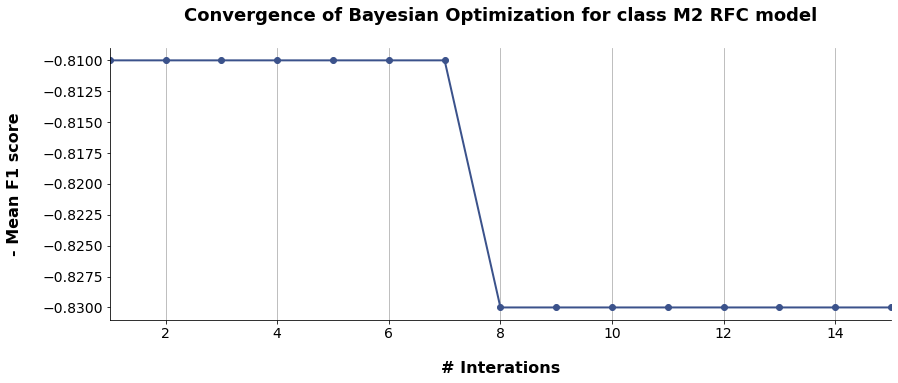

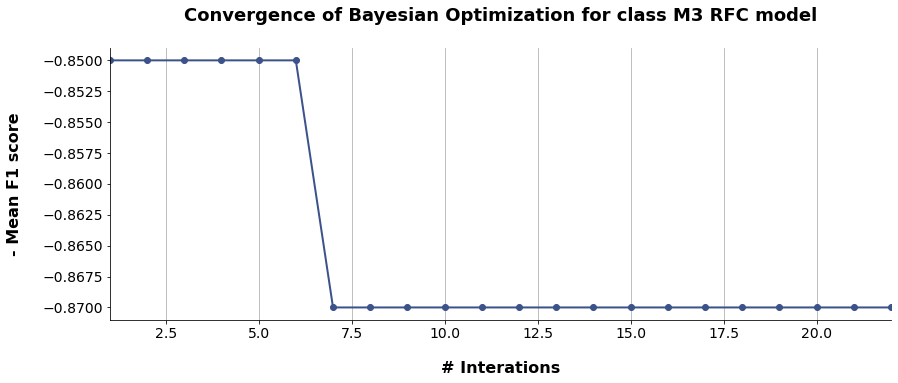

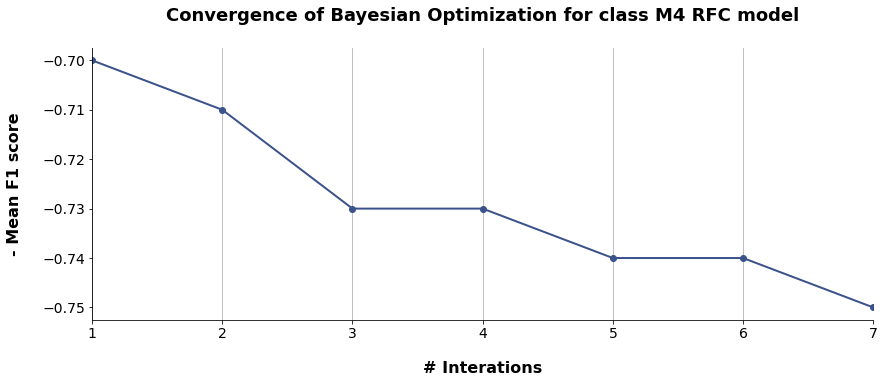

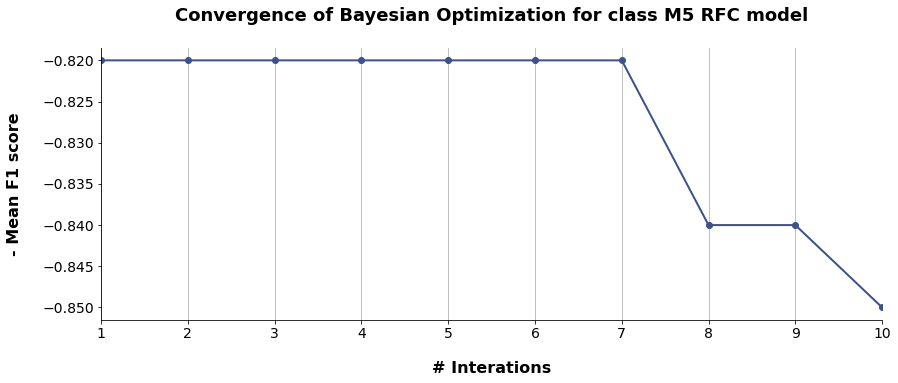

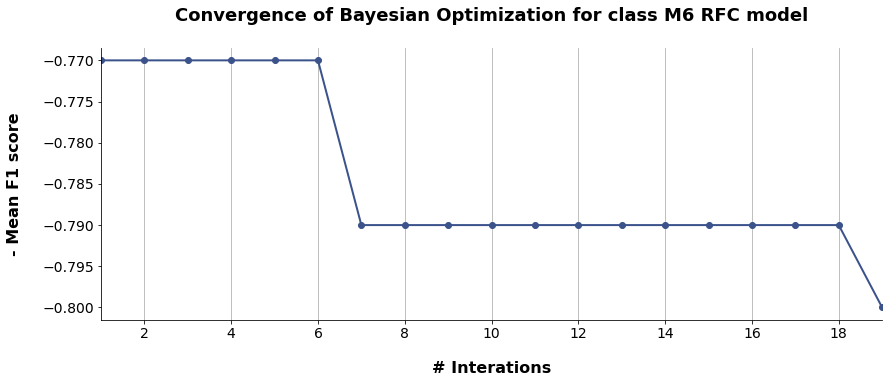

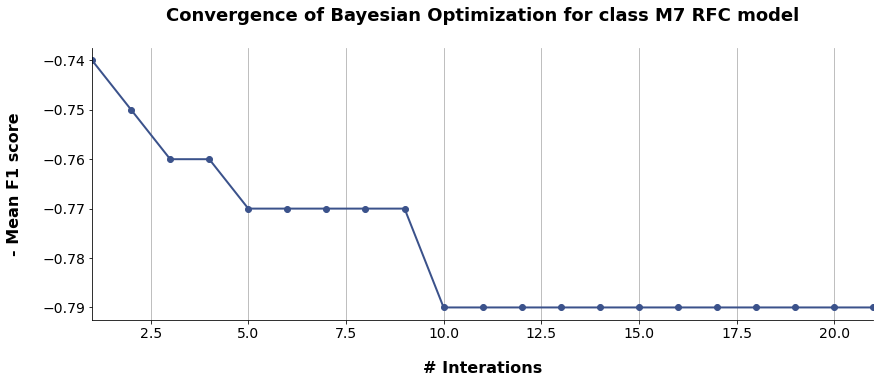

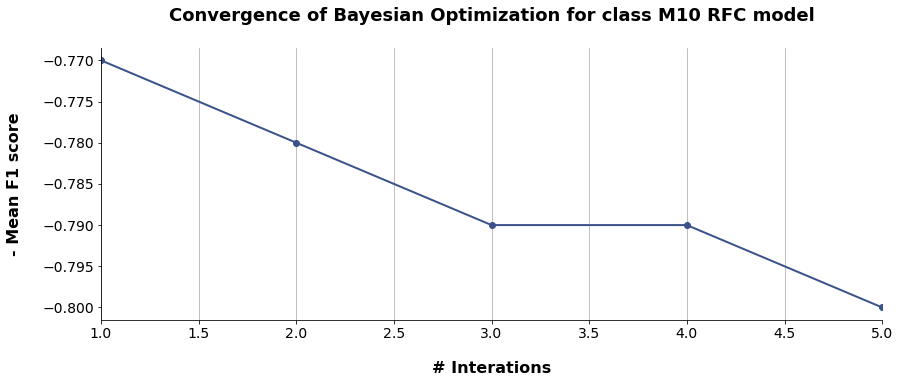

In [11]:
# For tuning
search_space = [Integer(1, 50, name='min_samples_leaf'),
                Integer(2, 50, name='min_samples_split'), 
                Categorical(['log2', 'sqrt'], name='max_features'),
                Integer(10, 200, name='n_estimators'),
                Integer(5, 200, name='max_depth'),
                Categorical(['gini', 'entropy'], name='criterion'),
                Categorical([True, False], name='bootstrap')]

# Target classes
target_classes = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']
target_classes_for_tuning = ['M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M10']
threshold_for_tuning = [0.85, 0.90, 0.75, 0.85, 0.80, 0.80, 0.80]

# Initial X point
x_initial = {'min_samples_leaf': 1,
            'min_samples_split': 2,
            'max_features': 'sqrt',
            'n_estimators': 100,
            'max_depth': 200,
            'criterion': 'gini',
            'bootstrap': True}

#Path external evaluation
path_external = os.path.join(os.getcwd(),
                            os.pardir,os.pardir,
                            'output', 'models',
                            'multi-model binary classification'.replace(' ', '_'),
                            'external_evaluation.csv')
evaluated_class = pd.read_csv(path_external, usecols=['target_class'])['target_class'].tolist()

i = -1

for target_class in target_classes:
    
    if target_class not in evaluated_class:
    
        # Opening the dataset
        selected_id = str(selected_ids[target_class])
        file_id = ids[selected_id]
        X_train, Y_train, X_test, Y_test = open_dataset(selected_id, file_id, drive, test=True)

        if target_class in target_classes_for_tuning:
            i += 1

            print(f'Tuning hyperparameters for class {target_class}')

            # Fixed parameters
            model_params = {
                'ccp_alpha': 0.0,
                'class_weight': 'balanced',
                'max_leaf_nodes': None,
                'max_samples': None,
                'min_impurity_decrease': 0.0,
                'min_weight_fraction_leaf': 0.0,
                'n_jobs': 4,
                'oob_score': False,
                'random_state': 0,
                'verbose': 0,
                'warm_start': False,
            }

            # Initial Y point
            y_initial = - base_mean_f1[target_class]

            # Tuning
            # We run Bayesian Optimization with Gaussian Processes, which uses a Multidimensional Gaussian distribution as surrogate model.
            # The objective function is the negative of the the mean f1 score for 5-fold cross-validation
            # A threshold of 0.75 for the f1 score to stop the optimization is used
            # n_iter_search = number of iterations for the Bayesian Optimization
            # time_to_optimize = the budget time to optimize the Bayesian Optimization

            start = time.time()

            tuning_result = rfc_parameter_tuning(X_train, Y_train.reshape(Y_train.shape[0],),
                                            'multi-model binary classification',
                                            model_params, search_space,
                                            time_to_optimize=14400,
                                            n_calls=200,
                                            threshold=threshold_for_tuning[i], 
                                            verbose=False,
                                            x_initial=x_initial,
                                            y_initial=y_initial,
                                            n_initial_points=5,
                                            target_class=target_class)

            end = time.time()

            best_params = {'target_class': {target_class:
                                           {'model': {
                                'RFC': {'params': {**tuning_result['best_params'], **model_params}
                                       }
                                                    }
                                              }

                                           }
                          }

            # Saving the best parameters
            save_best_params('multi-model binary classification', best_params)

            print(f'The minimum for the objective function for class {target_class} is {tuning_result["best_objective"]}')
            print(f'The time actually spent for class {target_class} tuning {end - start} seconds')

            # Convergence drawing
            rfc_draw_convergence(tuning_result, 'multi-model binary classification', target_class=target_class)

            # Calling the best parameters
            best_params = best_params['target_class'][target_class]['model']['RFC']['params']

        else:

            # Default parameters
            best_params = {
                'bootstrap': True,
                'ccp_alpha': 0.0,
                'class_weight': 'balanced',
                'criterion': 'gini',
                'max_depth': 200,
                'max_features': 'sqrt',
                'max_leaf_nodes': None,
                'max_samples': None,
                'min_impurity_decrease': 0.0,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'min_weight_fraction_leaf': 0.0,
                'n_estimators': 100,
                'n_jobs': 4,
                'oob_score': False,
                'random_state': 0,
                'verbose': 0,
                'warm_start': False,
            }

            # Saving the best parameters
            save_best_params('multi-model binary classification',
                             {'target_class': {target_class: {'model': {
                                'RFC': {'params': best_params
                                       }
                                                    }
                                              }

                                           }}
                            )

        # cross-validation with the found hyperparameters
        cv_result, classifier = performing_cross_validation('RFC', best_params,
                                                            X_train, Y_train.reshape(Y_train.shape[0],),
                                                            'multi-model binary classification',
                                                            for_tuning=False, threshold=0.75,
                                                            return_model=True)

        # Saving cross-validation results for tuning
        df_target_result = pd.DataFrame({key: [val] for key, val in cv_result.items()})
        path_cv_tuning = os.path.join(os.getcwd(),
                                os.pardir,os.pardir,
                                'output', 'models',
                                'multi-model binary classification'.replace(' ', '_'),
                                'cv_best_params.csv')
        if os.path.isfile(path_cv_tuning):
            df_target_result.to_csv(path_cv_tuning, mode='a', header=False, index=False)
        else:
            df_target_result.to_csv(path_cv_tuning, index=False)

        # External evaluation
        Y_test_hat = classifier.predict(X_test)

        df_external = pd.DataFrame({'test_accuracy': [prediction_evaluation(Y_test.reshape(Y_test.shape[0],), Y_test_hat)],
                                   'test_f1': [prediction_evaluation(Y_test.reshape(Y_test.shape[0],), Y_test_hat, metric="f1")],
                                   'target_class': [target_class]})
        df_external.to_csv(path_external, mode='a', header=False, index=False)

        # Saving model
        path_model = os.path.join(os.getcwd(),
                                os.pardir,os.pardir,
                                'output', 'models',
                                'multi-model binary classification'.replace(' ', '_'),
                                f'RFC_for_class_{target_class}.pkl')
        pickle.dump(classifier, open(path_model, 'wb'))